In [1]:
import pandas as pd
df = pd.read_csv("movies.csv")

In [2]:
import pandas as pd

try:
    answersDataFrane = pd.read_csv("AnkietaOFilmachIMDB.csv", encoding='latin1', sep=';')
    print("File loaded successfully with 'latin1' encoding and comma delimiter.")
except UnicodeDecodeError:
    try:
        answersDataFrane = pd.read_csv("AnkietaOFilmachIMDB.csv", encoding='windows-1252', sep=';')
        print("File loaded successfully with 'windows-1252' encoding and comma delimiter.")
    except Exception as e:
        print(f"An error occurred with encoding or delimiter: {e}")
except FileNotFoundError:
    print("Error: The file 'AnkietaOFilmachIMDB.csv' was not found.")

File loaded successfully with 'latin1' encoding and comma delimiter.


## Data preparation for user data

In [3]:
answersDataFrane.replace(-1, pd.NA).describe(include='all')


,whose_rating,rating_kuby,rating_ali
count,249,50.00000,50
unique,249,NaN,7
top,12 Years a Slave,NaN,8
freq,1,NaN,15
mean,NaN,6.84000,NaN
std,NaN,1.26749,NaN
min,NaN,5.00000,NaN
25%,NaN,6.00000,NaN
50%,NaN,7.00000,NaN
75%,NaN,8.00000,NaN


In [4]:
answersDataFrane.head()

,whose_rating,rating_kuby,rating_ali
0,12 Years a Slave,NaN,NaN
1,1917,NaN,NaN
2,2001: A Space Odyssey,NaN,NaN
3,3 Idiots,NaN,NaN
4,A Beautiful Mind,NaN,NaN


In [5]:
answersDataFrane.dtypes

whose_rating     object
rating_kuby     float64
rating_ali       object
dtype: object

In [6]:
def rating_cleaner(CurrentDataFrame, rating_name):

    if CurrentDataFrame[rating_name].dtype!="int64":

        if CurrentDataFrame[rating_name].dtype!="float64":
            CurrentDataFrame[rating_name] = CurrentDataFrame[rating_name].astype(str).str.strip()
            CurrentDataFrame[rating_name] = pd.to_numeric(CurrentDataFrame[rating_name], errors='coerce')

        CurrentDataFrame = CurrentDataFrame.fillna(-1)    
        if CurrentDataFrame[rating_name].dtype == 'float64':
            CurrentDataFrame[rating_name] = CurrentDataFrame[rating_name].astype('int64')
    return CurrentDataFrame

In [7]:
for col in answersDataFrane.columns[1:]:
    answersDataFrane = rating_cleaner(answersDataFrane, col)

In [8]:
df = df.sort_values(by="name")

In [9]:
for col in answersDataFrane.columns[1:]:
    extracted_col = answersDataFrane[col]
    df = pd.concat([df, extracted_col], axis=1)

## Data preparation for project

### usuniecie czesci kolumn

In [10]:
if "img_link" in df.columns: df.drop(columns="img_link", inplace=True)
if "id" in df.columns: df.drop(columns="id", inplace=True)
if "cast_id" in df.columns: df.drop(columns="cast_id", inplace=True)
if "director_id" in df.columns: df.drop(columns="director_id", inplace=True)
if "writter_id" in df.columns: df.drop(columns="writter_id", inplace=True)

### funkcja do zmiany stringu w listę

In [11]:
def split_if_string(value):
    if isinstance(value, str):
        return value.split(',')
    return value # Return as is if not a string (e.g., already a list or NaN)

In [12]:
df['cast_name'] = df['cast_name'].apply(split_if_string)
df['writter_name'] = df['writter_name'].apply(split_if_string)
df['director_name'] = df['director_name'].apply(split_if_string)
df['genre'] = df['genre'].apply(split_if_string)

In [13]:
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')

In [14]:
bins = [0, 60, 90, 120, 150, 180, float('inf')]
labels = [0, 1, 2, 3, 4, 5]
#labels = ['very short', 'short', 'normal', 'pretty long', 'long', 'very long']


df['duration_category'] = pd.cut(df['duration'], bins=bins, labels=labels, right=False)


In [15]:
df['duration_category'] = pd.to_numeric(df['duration_category'], errors='coerce')

# Przygotowanie pod Drzewo losowe

### usuniecie nazw, oraz rank

In [16]:
if "name" in df.columns: df.drop(columns="name", inplace=True)
if "rank" in df.columns: df.drop(columns="rank", inplace= True)

### function for one-hot encoding

In [17]:
def one_hot_encode (DataFrame, column_names, prefixes):
    dfInWork = DataFrame
    for column_name, prefix in zip(column_names, prefixes):
        if column_name in dfInWork.columns: 
            df_exploded = dfInWork[column_name].explode()
            df_dummies = pd.get_dummies(df_exploded, prefix=prefix)
            df_genres_encoded = df_dummies.groupby(df_dummies.index).max()
            df_final = pd.merge(dfInWork, df_genres_encoded, left_index=True, right_index=True, how='left')
            dfInWork = df_final.drop(column_name, axis=1)
        else:
            print(f"ERROR, column {column_name} non existing")
    return dfInWork


In [18]:
df = one_hot_encode(df, ("genre", "cast_name", "writter_name", "director_name"), prefixes = ("g_", "c_", "w_", "d_") )


In [19]:
certificate_numbers = ([])
certificate_labels = df["certificate"].unique()

i = 0
for unique in certificate_labels:
    certificate_numbers.append(i)
   # certificate_labels.append(unique)
    i+=1

label_to_number_map = dict(zip(certificate_labels, certificate_numbers))

mapping = {
    "certificate": label_to_number_map
}

df.replace(mapping, inplace=True)



C:\Users\kubah\AppData\Local\Temp\ipykernel_14844\3106441032.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(mapping, inplace=True)


In [20]:
df = df.drop(columns="duration")

### pozbycie się nulli

In [21]:
df = df.dropna()

## pozbycie się ciągłości

In [22]:
df["imdb_rating"] *=10

In [23]:

df.replace(mapping, inplace=True)
for i in df.columns:
    if df[i].dtype == 'float64':
        df[i] = df[i].astype('int64')

### pozbycie się rzadkich aktorów

In [24]:
deleted = 0
undeleted = 0

for column in df.columns:
    if df[column].dtype == "bool":
        if df[column].values.sum() < 3:
            df.drop(columns=column, inplace=True)
            deleted += 1
        else:
            undeleted+=1
print(f"undeleted: {undeleted}")
print(f"deleted: {deleted}")

undeleted: 190
deleted: 4277


### discretising year and number of votes

sprawdzenie wartości dla danych lat

In [25]:
bins = [0, 1944, 1960, 1968, 1994, 2007, 2015, float('inf')]
labels = [0, 1, 2, 3, 4, 5, 6]
#labels = ['very short', 'short', 'normal', 'pretty long', 'long', 'very long']


df['year_category'] = pd.cut(df['year'], bins=bins, labels=labels, right=False)

In [26]:
df = df.drop(columns="year")

### to samo, ale z liczbą głosów

od 1740000 są wysokie,
from 1030000 moderate

In [27]:
voting_ranges = [0, 2*10**5, 4*10**5, 7*10**5, 10**6, float('inf')]
labels = [0, 1, 2, 3, 4, 5, 6]
#labels = ['very short', 'short', 'normal', 'pretty long', 'long', 'very long']


df['imbd_votes_category'] = pd.cut(df['imbd_votes'], bins=bins, labels=labels, right=False)
df = df.drop(columns="imbd_votes")

# Split The DataSet

In [28]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.neural_network import MLPClassifier

In [29]:
df.head()

,imdb_rating,certificate,rating_kuby,rating_ali,duration_category,g__Action,g__Adventure,g__Animation,g__Biography,g__Comedy,...,d__Martin Scorsese,d__Pete Docter,d__Peter Jackson,d__Quentin Tarantino,d__Ridley Scott,d__Sergio Leone,d__Stanley Kubrick,d__Steven Spielberg,year_category,imbd_votes_category
4,90,0,-1,-1,2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1,6
181,81,1,-1,-1,3,False,False,False,True,False,...,False,False,False,False,False,False,False,False,5,6
121,82,2,-1,-1,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,6,6
88,83,0,-1,-1,3,False,True,False,False,False,...,False,False,False,False,False,False,True,False,3,6
86,84,3,6,9,4,False,False,False,False,True,...,False,False,False,False,False,False,False,False,5,6


Choice of surveyed person

In [30]:
'''chosenRating = "rating_ali"
for col in df.columns:
    if col.startswith("rating_") and col != chosenRating:
        df.drop(columns=col, inplace=True)



df = df[df[chosenRating] != -1]
X = df.drop(chosenRating, axis=1)
y = df[chosenRating]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
'''

'chosenRating = "rating_ali"\nfor col in df.columns:\n    if col.startswith("rating_") and col != chosenRating:\n        df.drop(columns=col, inplace=True)\n\n\n\ndf = df[df[chosenRating] != -1]\nX = df.drop(chosenRating, axis=1)\ny = df[chosenRating]\n\n# Split the data into training and test sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)\n'

# Train & test the dataset

In [31]:
'''
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
'''

'\nrf = RandomForestClassifier(n_estimators=10)\nrf.fit(X_train, y_train)\ny_pred = rf.predict(X_test)\n'

In [32]:
'''AnkietaOFilmachIMDB.csv

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import Counter # Import Counter for easily counting occurrences
from matplotlib.colors import Normalize # For normalizing counts to colormap range


minimal = y_test.min() if y_test.min() < y_pred.min() else y_pred.min()
maximal = y_test.max() if y_test.max() > y_pred.max() else y_pred.max()

x = range(minimal,maximal+1,1)
y = range(minimal,maximal+1,1)

data_points = list(zip(y_test, y_pred))

point_counts = Counter(data_points)

unique_points = list(point_counts.keys())
counts = np.array(list(point_counts.values()))

min_count = counts.min()
max_count = counts.max()

#('viridis', 'plasma', 'hot', 'magma', 'cool')
cmap = cm.plasma

norm = Normalize(vmin=min_count, vmax=max_count if max_count > min_count else min_count + 1)


plt.figure(figsize=(10, 8)) 

for (test_val, pred_val) in unique_points:
    count = point_counts[(test_val, pred_val)]
    color = cmap(norm(count))
    plt.scatter(test_val, pred_val, color=color, s=50, alpha=0.7)

plt.plot(x, y, color='gray', alpha=0.6, linestyle='--', label='Idealne przewidywanie')

plt.xlabel("Odpowiedź człowieka")
plt.ylabel("Przewidziana odpowiedź przez algorytm")

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Liczba punktów o tej samej pozycji')


chosenRating_name = chosenRating.replace("rating_", "")
plt.title(f"Przewidywanie oceny ankietowanego ( {chosenRating_name} ) wybranych filmów z top250 filmów IMDb")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()
'''


'AnkietaOFilmachIMDB.csv\n\nimport matplotlib.pyplot as plt\nimport matplotlib.cm as cm\nfrom collections import Counter # Import Counter for easily counting occurrences\nfrom matplotlib.colors import Normalize # For normalizing counts to colormap range\n\n\nminimal = y_test.min() if y_test.min() < y_pred.min() else y_pred.min()\nmaximal = y_test.max() if y_test.max() > y_pred.max() else y_pred.max()\n\nx = range(minimal,maximal+1,1)\ny = range(minimal,maximal+1,1)\n\ndata_points = list(zip(y_test, y_pred))\n\npoint_counts = Counter(data_points)\n\nunique_points = list(point_counts.keys())\ncounts = np.array(list(point_counts.values()))\n\nmin_count = counts.min()\nmax_count = counts.max()\n\n#(\'viridis\', \'plasma\', \'hot\', \'magma\', \'cool\')\ncmap = cm.plasma\n\nnorm = Normalize(vmin=min_count, vmax=max_count if max_count > min_count else min_count + 1)\n\n\nplt.figure(figsize=(10, 8)) \n\nfor (test_val, pred_val) in unique_points:\n    count = point_counts[(test_val, pred_val)]

In [33]:
'''from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10, 20), random_state=5)


clf.fit(X_train, y_train)'''

"from sklearn.neural_network import MLPClassifier\n\nclf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10, 20), random_state=5)\n\n\nclf.fit(X_train, y_train)"

In [34]:
'''y_pred = clf.predict(X_test)'''

'y_pred = clf.predict(X_test)'

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
from sklearn.neural_network import MLPRegressor

In [37]:
df.head()

,imdb_rating,certificate,rating_kuby,rating_ali,duration_category,g__Action,g__Adventure,g__Animation,g__Biography,g__Comedy,...,d__Martin Scorsese,d__Pete Docter,d__Peter Jackson,d__Quentin Tarantino,d__Ridley Scott,d__Sergio Leone,d__Stanley Kubrick,d__Steven Spielberg,year_category,imbd_votes_category
4,90,0,-1,-1,2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1,6
181,81,1,-1,-1,3,False,False,False,True,False,...,False,False,False,False,False,False,False,False,5,6
121,82,2,-1,-1,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,6,6
88,83,0,-1,-1,3,False,True,False,False,False,...,False,False,False,False,False,False,True,False,3,6
86,84,3,6,9,4,False,False,False,False,True,...,False,False,False,False,False,False,False,False,5,6


In [139]:
def calculate_average_human_ai_difference(xs, ys):
    AvgDifference = 0
    for (x,y) in zip(xs, ys):
        AvgDifference += abs(x-y)**3
    AvgDifference /= len(xs)
    return AvgDifference

def test_setups(dataFrame, numberOfIterations, probeSize, predictColumns, neuralNetworkParametersSets, getPredictions):
    savedTestPredSet = ([])
    globalParameterAverageDifferenceMeanArray = ([])
    globalColumnAverageDifferenceMeanArray = ([])
    
# - - - - - - - - - - - - Calculating for every paramether set - - - - - - - - - - - - 
    for neuralNetworkParametersSet in neuralNetworkParametersSets:
        parameterAverageDifferenceMeanArray = ([])
        # Get the data (ready for sgd and adam)
     #   activation, solver, alpha, learning_rate_init, hidden_layer_sizes, max_iter = neuralNetworkParametersSet
        
        #Mean of average difference for one parameter set
        parametersAverageDifferenceMean = 0

        # Mean of average differences for every one column saved
        columnAverageDifferenceMeanArray = ([])
       # temporaryDataFrame = uneditedDataFrame.copy()
    # - - - - - - - - - - - - Calculating for every user input - - - - - - - - - - - - 
        for predictColumn in predictColumns:
        #    temporaryDataFrame = uneditedDataFrame.copy()
            # Mean of average differences for one column
            columnAverageDifferenceMean = 0   
        # - - - - - - - - - - - - Calculating for every iteration - - - - - - - - - - - - 
            for iteration in range(0, numberOfIterations, 1):
                temporaryDataFrame = dataFrame.copy()


                # Drop every column with "rating_" that isnt the one to be predicted
                # Drop every column with "rating_" that isnt the one to be predicted
                for col in list(temporaryDataFrame.columns):
                    if col.startswith("rating_") and col != predictColumn:
                        # Added: Check if column still exists before attempting to drop
                        if col in temporaryDataFrame.columns:
                            temporaryDataFrame.drop(columns=col, inplace=True)

                # Added: Check if predictColumn exists after dropping other columns
                if predictColumn not in temporaryDataFrame.columns:
                    print(f"Warning: predictColumn '{predictColumn}' not found in temporaryDataFrame after column dropping. Skipping iteration.")
                    continue # Skip this iteration if the column is missing

                # Getting rid of unfilled data (to be used in the future)
                temporaryDataFrame = temporaryDataFrame[temporaryDataFrame[predictColumn] != -1]

                # Added: Check if the DataFrame became empty after filtering
                if temporaryDataFrame.empty:
                    print(f"Warning: temporaryDataFrame became empty after filtering for '{predictColumn}'. Skipping iteration.")
                    continue # Skip this iteration if no data remains


                # Splitting the dataset into train and test


                
                X = temporaryDataFrame.drop(predictColumn, axis=1)
                y = temporaryDataFrame[predictColumn]
                XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=probeSize, random_state=42)

                # Training the network
                clf = MLPRegressor(**neuralNetworkParametersSet)
              #  clf = MLPClassifier(activation = activation, solver=solver, alpha=alpha,
               #                     learning_rate_init = learning_rate_init,
                #                    hidden_layer_sizes=hidden_layer_sizes, max_iter = max_iter)
                
                x_scaler = StandardScaler()
                y_scaler = StandardScaler()
                X_train_scaled = x_scaler.fit_transform(XTrain)
                X_test_scaled = x_scaler.transform(XTest)
                y_train_scaled = y_scaler.fit_transform(yTrain.values.reshape(-1, 1))


                clf.fit(X_train_scaled, y_train_scaled.ravel())

                # Testing the network
                y_pred_scaled = clf.predict(X_test_scaled)
                yPred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

                columnAverageDifferenceMean += calculate_average_human_ai_difference(yTest, yPred)
                if getPredictions:
                    savedTestPredSet = (yTest, yPred)
            # Mean of average difference in current column prediction
            columnAverageDifferenceMean /= numberOfIterations
            # Saving such mean
            columnAverageDifferenceMeanArray.append(columnAverageDifferenceMean)

        # Mean of average difference in current parameter set
        parametersAverageDifferenceMean = np.mean(columnAverageDifferenceMeanArray)
        parameterAverageDifferenceMeanArray.append(parametersAverageDifferenceMean)
        globalColumnAverageDifferenceMeanArray.append(columnAverageDifferenceMeanArray)

    #globalParameterAverageDifferenceMeanArray.append(parametersAverageDifferenceMean)
       # print("Appending")
        globalParameterAverageDifferenceMeanArray.append(parameterAverageDifferenceMeanArray) # Use extend to flatten if parameterAverageDifferenceMeanArray is a list of single values
    return globalParameterAverageDifferenceMeanArray, globalColumnAverageDifferenceMeanArray, savedTestPredSet




In [39]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore all ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [293]:
import itertools

predictColumns = ("rating_kuby", "rating_ali")


activationSet = ("relu",)
solverSet = ("adam",)
alphaSet = (0.1, )
learning_rate = ("adaptive",)
learning_rate_initSet =  (0.1,)
hidden_layer_sizesSet = ((8,16, 32, 16, 8),)
max_iterSet = (100000, )

# Generate all combinations
neuralNetworkParametersSets = []
for activation, solver, alpha, learning_rate, learning_rate_init, hidden_layer_sizes, max_iter in itertools.product(
    activationSet,
    solverSet,
    alphaSet,
    learning_rate,
    learning_rate_initSet,
    hidden_layer_sizesSet,
    max_iterSet
):
    param_set = {
        "activation": activation,
        "solver": solver,
        "alpha": alpha,
        "learning_rate": learning_rate,
        "learning_rate_init": learning_rate_init,
        "hidden_layer_sizes": hidden_layer_sizes,
        "max_iter": max_iter
    }
    neuralNetworkParametersSets.append(param_set)

print(f"DEBUG: Number of neuralNetworkParametersSets generated: {len(neuralNetworkParametersSets)}")
print(f"DEBUG: Contents of neuralNetworkParametersSets: {neuralNetworkParametersSets}")

parameter, _, globalTrainingSet = test_setups(dataFrame = df, numberOfIterations = 1,
                                              probeSize = 0.3, predictColumns=predictColumns,neuralNetworkParametersSets=neuralNetworkParametersSets,
                                              getPredictions=True)
print(parameter)
print(globalTrainingSet)

DEBUG: Number of neuralNetworkParametersSets generated: 1
DEBUG: Contents of neuralNetworkParametersSets: [{'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (8, 16, 32, 16, 8), 'max_iter': 100000}]
[[9.498933942990266]]
(213     7
32      7
228     5
8       8
218     9
177     7
143    10
237     8
172     8
205     8
67      9
37      8
55      9
208     8
246     9
Name: rating_ali, dtype: int64, array([[9.63627568],
       [7.95172911],
       [6.72610512],
       [7.92953108],
       [7.93198057],
       [8.93184105],
       [6.37769377],
       [8.49329626],
       [8.41218393],
       [8.70928031],
       [5.06552351],
       [8.74302417],
       [5.0029835 ],
       [6.82208208],
       [5.84154294]]))


In [41]:

tab_values = [[1.1978021978021975], [1.2692307692307692], [1.1428571428571428], [1.2252747252747254], [1.1538461538461537], [1.1868131868131866], [1.1208791208791211], [1.2362637362637363], [1.2417582417582418], [1.1428571428571428], [1.0934065934065935], [1.0549450549450547], [1.1153846153846154], [1.1648351648351647], [1.1538461538461537], [1.10989010989011], [1.192307692307692], [1.1813186813186813], [1.1318681318681318], [1.1593406593406592], [1.2637362637362637], [1.0824175824175821], [1.1318681318681318], [1.1043956043956045], [1.065934065934066], [1.2472527472527473], [1.0714285714285714], [1.3296703296703298], [1.346153846153846], [1.2692307692307692], [1.3406593406593408], [1.0879120879120878], [1.1373626373626373], [1.1483516483516483], [1.142857142857143], [1.1978021978021978], [1.0604395604395604], [1.1263736263736264], [1.1758241758241756], [1.0824175824175823], [1.0494505494505493], [1.2142857142857144], [1.1263736263736264], [1.1373626373626373], [1.1868131868131868], [1.1813186813186811], [1.120879120879121], [1.1868131868131868], [1.197802197802198], [1.1318681318681318], [1.1428571428571428], [1.2472527472527473], [1.2637362637362637], [1.2417582417582418], [1.1813186813186813], [1.1703296703296702], [1.1648351648351647], [1.1758241758241756], [1.10989010989011], [1.2527472527472527], [1.10989010989011], [1.1648351648351647], [1.2472527472527473], [1.263736263736264], [1.1813186813186811], [1.1373626373626373], [1.098901098901099], [1.2252747252747254], [1.2692307692307692], [1.1043956043956042], [1.1648351648351647], [1.0934065934065933], [1.1263736263736264], [1.10989010989011], [1.2032967032967035], [1.346153846153846], [1.2417582417582416], [1.2197802197802197], [1.1923076923076923], [1.1538461538461537], [1.0714285714285716], [1.120879120879121], [1.1153846153846154], [1.1648351648351647], [1.2747252747252746], [1.0714285714285712], [1.0769230769230769], [1.3241758241758244], [1.1318681318681318], [1.197802197802198], [1.2142857142857144], [1.1703296703296702], [1.2417582417582418], [1.0439560439560438], [1.2087912087912085], [1.054945054945055], [1.2252747252747254], [1.3186813186813187], [1.10989010989011], [1.1098901098901097], [1.1373626373626373], [1.2472527472527473], [1.2362637362637363], [1.0384615384615383], [1.2582417582417582], [1.065934065934066], [1.2637362637362637], [1.120879120879121], [1.0934065934065933], [1.0879120879120878], [1.0934065934065935], [1.120879120879121], [1.1483516483516483], [1.1263736263736264], [1.120879120879121], [1.1263736263736264], [1.1428571428571428], [1.0604395604395604], [1.0274725274725274], [1.0769230769230769], [1.0769230769230769], [1.302197802197802], [1.2142857142857142], [1.1978021978021975], [1.412087912087912], [1.3681318681318682], [1.3186813186813187], [1.2252747252747254], [1.2252747252747254], [1.0769230769230766], [1.2307692307692308], [1.2362637362637363], [1.1758241758241756], [1.0769230769230769], [1.1868131868131868], [1.1813186813186816], [1.2417582417582418], [1.1263736263736261], [1.1263736263736264], [1.010989010989011], [1.1043956043956045], [1.208791208791209], [1.291208791208791], [1.0714285714285714], [1.2747252747252749], [1.3131868131868134], [1.1043956043956045], [1.1703296703296702], [1.2197802197802199], [1.1428571428571428], [1.1373626373626373], [1.3241758241758244], [1.214285714285714], [1.1593406593406592], [1.2802197802197801], [1.0824175824175823], [1.0384615384615383], [1.1758241758241759], [1.1593406593406592], [1.0769230769230769], [1.1758241758241756], [1.1703296703296706], [1.225274725274725], [1.225274725274725], [1.1043956043956045], [1.1758241758241756], [1.1428571428571426], [1.120879120879121], [1.1978021978021975], [1.2252747252747251], [1.186813186813187], [1.0824175824175826], [1.1868131868131868], [1.3351648351648353], [1.2417582417582418], [1.2582417582417582], [1.1043956043956042], [1.2802197802197801], [1.2692307692307692], [1.1703296703296702], [1.1648351648351647], [1.1043956043956045], [1.1703296703296702], [1.087912087912088], [1.1428571428571428], [1.1043956043956045], [1.2472527472527473], [1.2747252747252746], [1.2362637362637363], [1.120879120879121], [1.2417582417582418], [1.2252747252747254], [1.2142857142857142], [1.2692307692307692], [1.3461538461538463], [1.0934065934065933], [1.1538461538461537], [1.2802197802197801], [1.1593406593406592], [1.1813186813186811], [1.2197802197802199], [1.1538461538461537], [1.10989010989011], [1.120879120879121], [1.2197802197802197], [1.120879120879121], [1.1263736263736264], [1.2637362637362637], [1.1373626373626373], [1.1153846153846154], [1.1428571428571428], [1.0439560439560438], [1.3076923076923075], [1.0054945054945055], [1.0604395604395604], [1.1373626373626373], [1.2417582417582418], [1.2087912087912085], [1.1483516483516483], [1.0494505494505493], [1.2197802197802197], [1.3351648351648353], [1.175824175824176], [1.1318681318681318], [1.2417582417582418], [1.3021978021978022], [1.2747252747252749], [1.2637362637362637], [1.054945054945055], [1.0604395604395604], [1.0549450549450547], [1.1318681318681318], [1.2032967032967035], [1.1428571428571428], [1.1648351648351647], [1.120879120879121], [1.10989010989011], [1.1868131868131866], [1.2527472527472527], [1.192307692307692], [1.197802197802198], [1.1813186813186811], [1.263736263736264], [1.2252747252747254], [1.2582417582417582], [1.3296703296703294], [1.3846153846153846], [1.3186813186813189], [1.3186813186813189], [1.2637362637362637], [1.2967032967032968], [1.3461538461538463], [1.2252747252747251], [1.3186813186813189], [1.4615384615384615], [1.4285714285714284], [1.467032967032967], [1.3296703296703298], [1.5439560439560438], [1.5934065934065933], [1.521978021978022], [1.4670329670329672], [1.4560439560439562], [1.521978021978022], [1.0934065934065933], [1.3626373626373627], [1.1483516483516485], [1.2032967032967035], [1.208791208791209], [1.3406593406593408], [1.3681318681318682], [1.1538461538461537], [1.3516483516483517], [1.2967032967032968], [1.3296703296703294], [1.2912087912087915], [1.3571428571428572], [1.5439560439560438], [1.39010989010989], [1.3461538461538463], [1.5054945054945055], [1.423076923076923], [1.5494505494505495], [1.5054945054945055], [1.521978021978022], [1.6813186813186816], [1.5604395604395604], [1.489010989010989], [1.2582417582417584], [1.2362637362637363], [1.1923076923076923], [1.4175824175824174], [1.2857142857142856], [1.2472527472527473], [1.186813186813187], [1.2362637362637363], [1.3516483516483517], [1.2857142857142856], [1.4065934065934067], [1.4615384615384617], [1.4835164835164836], [1.4670329670329672], [1.291208791208791], [1.5], [1.467032967032967], [1.4560439560439562], [1.4835164835164836], [1.598901098901099], [1.587912087912088], [1.4450549450549453], [1.3956043956043955], [1.5989010989010988], [1.2307692307692308], [1.2197802197802194], [1.1813186813186813], [1.2252747252747254], [1.2967032967032968], [1.4560439560439562], [1.4230769230769231], [1.2637362637362637], [1.3571428571428572], [1.2362637362637363], [1.3516483516483517], [1.3241758241758241], [1.3076923076923077], [1.3736263736263736], [1.5494505494505495], [1.543956043956044], [1.5329670329670328], [1.4120879120879122], [1.6263736263736264], [1.4505494505494507], [1.6538461538461537], [1.5384615384615383], [1.4065934065934065], [1.3681318681318682], [1.3241758241758241], [1.2692307692307692], [1.3076923076923077], [1.2362637362637363], [1.3516483516483517], [1.2912087912087913], [1.3626373626373625], [1.3076923076923077], [1.4010989010989012], [1.2637362637362637], [1.4175824175824174], [1.39010989010989], [1.4175824175824177], [1.521978021978022], [1.5164835164835164], [1.5659340659340661], [1.3846153846153846], [1.2967032967032965], [1.4340659340659339], [1.521978021978022], [1.4670329670329672], [1.4340659340659343], [1.510989010989011], [1.6428571428571428], [1.2747252747252746], [1.379120879120879], [1.2857142857142856], [1.2252747252747251], [1.3131868131868134], [1.5274725274725274], [1.3956043956043955], [1.379120879120879], [1.434065934065934], [1.1703296703296702], [1.3846153846153846], [1.3681318681318682], [1.4340659340659343], [1.5934065934065935], [1.4615384615384617], [1.4505494505494507], [1.587912087912088], [1.5439560439560438], [1.4450549450549453], [1.3681318681318682], [1.478021978021978], [1.543956043956044], [1.4230769230769231], [1.4835164835164836], [1.065934065934066], [1.1868131868131868], [1.2307692307692306], [1.3351648351648353], [1.2857142857142858], [1.2692307692307692], [1.3571428571428572], [1.3186813186813184], [1.5054945054945055], [1.2857142857142856], [1.2582417582417582], [1.39010989010989], [1.4175824175824174], [1.5549450549450547], [1.4175824175824177], [1.5], [1.4065934065934067], [1.5439560439560438], [1.4505494505494505], [1.4835164835164836], [1.6263736263736264], [1.4065934065934067], [1.4505494505494505], [1.5054945054945055], [1.2087912087912087], [1.2472527472527473], [1.3571428571428572], [1.2307692307692306], [1.2692307692307692], [1.2417582417582418], [1.2967032967032965], [1.3461538461538463], [1.3516483516483517], [1.3021978021978025], [1.302197802197802], [1.4670329670329672], [1.4560439560439558], [1.554945054945055], [1.653846153846154], [1.4670329670329672], [1.4945054945054945], [1.4780219780219779], [1.5439560439560438], [1.478021978021978], [1.6483516483516483], [1.60989010989011], [1.5714285714285714], [1.5054945054945055], [1.2472527472527473], [1.1318681318681318], [1.3516483516483517], [1.2912087912087913], [1.302197802197802], [1.4395604395604396], [1.2307692307692308], [1.2857142857142856], [1.4230769230769234], [1.2912087912087913], [1.3736263736263736], [1.3351648351648353], [1.3461538461538463], [1.2472527472527473], [1.5054945054945055], [1.6318681318681318], [1.489010989010989], [1.4560439560439562], [1.5384615384615383], [1.4285714285714286], [1.6758241758241756], [1.4725274725274726], [1.5384615384615383], [1.5384615384615383], [1.1813186813186811], [1.2417582417582418], [1.3021978021978022], [1.39010989010989], [1.3076923076923075], [1.2967032967032968], [1.3131868131868134], [1.3681318681318682], [1.263736263736264], [1.2967032967032968], [1.3296703296703298], [1.3186813186813184], [1.6263736263736264], [1.4670329670329672], [1.3956043956043955], [1.4395604395604396], [1.489010989010989], [1.4725274725274726], [1.3626373626373627], [1.5164835164835164], [1.6153846153846154], [1.6538461538461537], [1.5164835164835164], [1.456043956043956], [1.054945054945055], [1.0329670329670328], [1.2472527472527473], [1.0879120879120878], [1.1263736263736264], [1.1318681318681318], [1.2637362637362637], [1.10989010989011], [1.291208791208791], [1.192307692307692], [1.0494505494505495], [1.1648351648351647], [1.1098901098901095], [1.0934065934065935], [1.120879120879121], [1.0549450549450547], [1.0989010989010988], [1.1593406593406592], [1.214285714285714], [1.1868131868131866], [1.098901098901099], [1.1428571428571428], [1.0549450549450547], [1.1263736263736264], [1.1593406593406592], [1.1263736263736264], [1.0549450549450547], [1.1043956043956042], [1.1043956043956042], [1.0824175824175823], [1.1098901098901097], [1.1483516483516483], [1.0604395604395604], [1.225274725274725], [1.0604395604395607], [1.098901098901099], [1.0769230769230769], [1.214285714285714], [1.1593406593406592], [1.120879120879121], [1.1318681318681318], [1.0384615384615383], [1.0164835164835164], [1.0714285714285712], [1.098901098901099], [1.1813186813186813], [1.1703296703296702], [1.1153846153846154], [1.1483516483516483], [1.1648351648351647], [1.1153846153846154], [1.2527472527472527], [1.0824175824175823], [1.1428571428571428], [1.098901098901099], [1.2692307692307694], [1.1923076923076923], [1.0769230769230769], [1.1813186813186811], [1.0714285714285716], [1.0659340659340661], [1.098901098901099], [1.0164835164835164], [1.120879120879121], [1.2472527472527473], [1.1153846153846154], [1.1043956043956045], [1.1153846153846154], [1.1593406593406592], [1.1868131868131866], [1.10989010989011], [1.2912087912087913], [1.0494505494505495], [1.0824175824175823], [1.1813186813186813], [1.2637362637362637], [1.0439560439560438], [1.10989010989011], [1.1263736263736264], [1.120879120879121], [1.1538461538461537], [1.1263736263736264], [1.1593406593406592], [1.1483516483516483], [1.120879120879121], [1.1703296703296702], [1.1263736263736264], [1.010989010989011], [1.0714285714285714], [1.0879120879120878], [1.1428571428571428], [1.192307692307692], [1.0769230769230769], [1.1538461538461537], [1.0439560439560438], [1.0164835164835164], [1.076923076923077], [1.1428571428571428], [1.208791208791209], [1.065934065934066], [1.0714285714285716], [1.120879120879121], [1.0769230769230769], [1.2032967032967032], [1.1593406593406594], [1.1538461538461537], [1.1758241758241756], [1.2527472527472527], [1.0714285714285714], [1.175824175824176], [1.1428571428571428], [1.1153846153846154], [1.0549450549450547], [1.0604395604395604], [1.2252747252747254], [1.1593406593406594], [1.0439560439560438], [1.021978021978022], [1.1318681318681318], [1.0549450549450547], [1.1538461538461537], [1.0824175824175823], [1.1703296703296702], [1.1648351648351647], [1.1593406593406592], [1.0604395604395602], [1.1373626373626373], [1.1813186813186811], [1.1373626373626373], [1.087912087912088], [1.1978021978021975], [1.0934065934065933], [1.021978021978022], [1.043956043956044], [1.054945054945055], [1.1813186813186811], [1.2142857142857144], [1.10989010989011], [1.192307692307692], [1.098901098901099], [1.0989010989010988], [1.0164835164835164], [1.1978021978021978], [1.120879120879121], [1.0934065934065935], [1.2032967032967032], [1.054945054945055], [1.1758241758241756], [1.1648351648351647], [1.225274725274725], [1.120879120879121], [1.0659340659340657], [1.1373626373626373], [1.0824175824175826], [1.0934065934065935], [1.098901098901099], [1.1373626373626373], [1.1318681318681318], [0.9945054945054945], [1.1648351648351647], [1.1483516483516483], [1.10989010989011], [1.1703296703296702], [1.2307692307692308], [1.1868131868131866], [1.0494505494505493], [1.1373626373626373], [1.0824175824175823], [1.1043956043956042], [1.2417582417582418], [1.1263736263736264], [1.087912087912088], [1.1593406593406592], [1.1483516483516483], [1.197802197802198], [1.1098901098901097], [1.1428571428571428], [1.1263736263736264], [1.0824175824175826], [1.1978021978021975], [1.1318681318681318], [1.1263736263736266], [1.10989010989011], [1.1483516483516483], [1.0934065934065935], [1.1043956043956045], [1.1813186813186811], [1.1318681318681318], [1.0714285714285714], [1.065934065934066], [1.1538461538461537], [0.9945054945054945], [1.1318681318681318], [1.1538461538461537], [1.1978021978021975], [1.0934065934065935], [1.1318681318681318], [1.1263736263736264], [1.0934065934065935], [1.0604395604395604], [1.120879120879121], [1.120879120879121], [1.1098901098901097], [1.0934065934065933], [1.1813186813186811], [1.1593406593406594], [1.0769230769230769], [1.1153846153846154], [1.0769230769230769], [1.186813186813187], [1.0934065934065935], [1.1538461538461537], [1.1813186813186811], [1.0329670329670328], [1.1318681318681318], [1.1153846153846154], [1.1483516483516483], [1.098901098901099], [1.1483516483516483], [1.175824175824176], [1.120879120879121], [1.1538461538461537], [1.1593406593406592], [1.208791208791209], [1.0769230769230769], [1.1153846153846154], [1.2252747252747251], [1.208791208791209], [1.1373626373626373], [1.1978021978021978], [1.0879120879120878], [1.291208791208791], [1.2472527472527473], [1.076923076923077], [1.0879120879120878], [1.1153846153846154], [1.1483516483516483], [1.043956043956044], [1.1703296703296702], [1.0934065934065935], [1.3241758241758244], [1.4285714285714284], [1.3571428571428572], [1.4120879120879122], [1.4065934065934067], [1.3681318681318682], [1.412087912087912], [1.401098901098901], [1.620879120879121], [1.4010989010989015], [1.2527472527472527], [1.4395604395604398], [1.2912087912087913], [1.39010989010989], [1.5824175824175826], [1.5], [1.6483516483516483], [1.5659340659340657], [1.521978021978022], [1.5], [1.576923076923077], [1.6153846153846154], [1.6263736263736264], [1.4670329670329672], [1.291208791208791], [1.1648351648351647], [1.4285714285714288], [1.4945054945054945], [1.5329670329670328], [1.4120879120879122], [1.642857142857143], [1.5714285714285712], [1.3406593406593408], [1.1483516483516483], [1.554945054945055], [1.4615384615384617], [1.3846153846153846], [1.4230769230769231], [1.5054945054945055], [1.4285714285714284], [1.521978021978022], [1.5054945054945055], [1.5604395604395602], [1.4670329670329672], [1.6868131868131866], [1.5714285714285712], [1.5109890109890112], [1.4945054945054945], [1.4615384615384617], [1.3956043956043958], [1.3736263736263736], [1.4835164835164836], [1.3571428571428572], [1.5054945054945055], [1.5934065934065935], [1.3186813186813187], [1.5879120879120878], [1.510989010989011], [1.4670329670329672], [1.3186813186813187], [1.2692307692307692], [1.4835164835164836], [1.5329670329670328], [1.5714285714285714], [1.4065934065934067], [1.5329670329670328], [1.445054945054945], [1.510989010989011], [1.697802197802198], [1.510989010989011], [1.3901098901098903], [1.5824175824175823], [1.3516483516483517], [1.4065934065934067], [1.2582417582417582], [1.4835164835164836], [1.4230769230769231], [1.3956043956043955], [1.4395604395604398], [1.5769230769230769], [1.598901098901099], [1.291208791208791], [1.5054945054945055], [1.3626373626373627], [1.3626373626373627], [1.3736263736263736], [1.3681318681318682], [1.5549450549450547], [1.5054945054945055], [1.5329670329670328], [1.6318681318681318], [1.401098901098901], [1.5494505494505493], [1.4285714285714286], [1.5], [1.708791208791209], [1.335164835164835], [1.4175824175824174], [1.6263736263736264], [1.3736263736263736], [1.39010989010989], [1.4285714285714288], [1.2087912087912085], [1.478021978021978], [1.510989010989011], [1.4010989010989012], [1.4560439560439562], [1.5824175824175823], [1.3681318681318682], [1.6428571428571428], [1.2692307692307692], [1.510989010989011], [1.4560439560439562], [1.5054945054945055], [1.5274725274725274], [1.5054945054945055], [1.6373626373626373], [1.3736263736263736], [1.5494505494505493], [1.5054945054945055], [1.4505494505494505], [1.4175824175824177], [1.5164835164835164], [1.5934065934065935], [1.478021978021978], [1.434065934065934], [1.406593406593407], [1.5054945054945057], [1.401098901098901], [1.3956043956043955], [1.39010989010989], [1.697802197802198], [1.554945054945055], [1.434065934065934], [1.4175824175824174], [1.489010989010989], [1.263736263736264], [1.5329670329670328], [1.5439560439560438], [1.565934065934066], [1.5329670329670328], [1.478021978021978], [1.565934065934066], [1.5494505494505493], [1.4175824175824177], [1.2417582417582418], [1.2912087912087913], [1.5714285714285714], [1.3351648351648353], [1.4175824175824179], [1.3681318681318682], [1.3021978021978022], [1.5769230769230769], [1.4065934065934067], [1.4175824175824174], [1.4120879120879122], [1.4065934065934065], [1.5549450549450547], [1.6043956043956045], [1.510989010989011], [1.467032967032967], [1.5934065934065935], [1.5384615384615385], [1.532967032967033], [1.5439560439560442], [1.6758241758241756], [1.5824175824175823], [1.5934065934065935], [1.2362637362637363], [1.4505494505494505], [1.3681318681318682], [1.4285714285714286], [1.489010989010989], [1.3681318681318682], [1.3461538461538463], [1.5], [1.5384615384615383], [1.4670329670329672], [1.3296703296703298], [1.4505494505494505], [1.5274725274725274], [1.5329670329670328], [1.4725274725274726], [1.3736263736263736], [1.4835164835164836], [1.4395604395604398], [1.4065934065934065], [1.620879120879121], [1.6098901098901097], [1.478021978021978], [1.4120879120879122], [1.5494505494505493], [1.3846153846153846], [1.5439560439560438], [1.3681318681318682], [1.401098901098901], [1.4890109890109893], [1.5494505494505495], [1.456043956043956], [1.4945054945054945], [1.3461538461538463], [1.2307692307692306], [1.4175824175824177], [1.4835164835164836], [1.3956043956043958], [1.576923076923077], [1.456043956043956], [1.5549450549450552], [1.620879120879121], [1.489010989010989], [1.4945054945054945], [1.6153846153846154], [1.521978021978022], [1.5054945054945055], [1.6043956043956045], [1.5494505494505495], [1.3626373626373627], [1.3076923076923077], [1.4505494505494505], [1.5494505494505495], [1.478021978021978], [1.478021978021978], [1.5604395604395604], [1.4230769230769231], [1.4505494505494505], [1.4560439560439562], [1.4835164835164836], [1.3186813186813189], [1.6318681318681318], [1.5494505494505493], [1.6428571428571428], [1.4395604395604396], [1.708791208791209], [1.4560439560439562], [1.5934065934065933], [1.4395604395604396], [1.6428571428571428], [1.5659340659340657], [1.6208791208791207], [1.521978021978022]]
tab_labels = [{'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 350}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}]

setValue = 1.05
lowEnough = []

for (x, label) in zip(tab_values, tab_labels):
    if x[0] < setValue:
        lowEnough.append((x[0], label))  # Extract the float from the list

# Sort by value in descending order
lowEnough.sort(reverse=False, key=lambda pair: pair[0])

# Print results
for val, label in lowEnough:
    print(f"Value: {val} for {label}")

Value: 0.9945054945054945 for {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}
Value: 0.9945054945054945 for {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 400}
Value: 1.0054945054945055 for {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 64), 'max_iter': 300}
Value: 1.010989010989011 for {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 350}
Value: 1.010989010989011 for {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 300}
Value: 1.0164835164835164 for {'activation': 't

In [42]:

tab_labels = [{'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 400}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}]


tab_values = [[1.1738461538461538], [1.1123076923076924], [1.1315384615384614], [1.08], [1.1161538461538463], [1.1284615384615386], [1.1715384615384619], [1.1392307692307695], [1.1199999999999997], [1.1084615384615386], [1.1615384615384614], [1.1384615384615386], [1.1046153846153843], [1.1000000000000003], [1.1215384615384616], [1.1938461538461538], [1.1653846153846157], [1.0915384615384616], [1.1423076923076927], [1.1546153846153848], [1.1046153846153843], [1.0976923076923077], [1.1092307692307692], [1.12], [1.1169230769230771], [1.1484615384615386], [1.1169230769230771], [1.1338461538461537], [1.1053846153846154], [1.1253846153846152], [1.123846153846154], [1.1530769230769229], [1.1146153846153846], [1.139230769230769], [1.1646153846153848], [1.17], [1.1169230769230771], [1.1461538461538465], [1.166153846153846], [1.1323076923076925], [1.1615384615384619], [1.1492307692307693], [1.2176923076923079], [1.2184615384615385], [1.146153846153846], [1.1561538461538463], [1.1700000000000004], [1.1907692307692308], [1.1215384615384614], [1.169230769230769], [1.1846153846153844], [1.137692307692308], [1.1338461538461542], [1.1392307692307693], [1.1323076923076925], [1.0976923076923075], [1.123076923076923], [1.1500000000000001], [1.1423076923076927], [1.1584615384615387], [1.1092307692307695], [1.1476923076923078], [1.1476923076923078], [1.1692307692307695]]

setValue = 1.1
lowEnough = []

for (x, label) in zip(tab_values, tab_labels):
    if x[0] < setValue:
        lowEnough.append((x[0], label))  # Extract the float from the list

# Sort by value in descending order
lowEnough.sort(reverse=False, key=lambda pair: pair[0])

# Print results
for val, label in lowEnough:
    print(f"Value: {val} for {label}")

Value: 1.08 for {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}
Value: 1.0915384615384616 for {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}
Value: 1.0976923076923075 for {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}
Value: 1.0976923076923077 for {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}


In [43]:

tab_labels = [{'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}]
tab_values = [[1.9615384615384617], [1.0769230769230769], [2.653846153846154], [2.269230769230769], [3.153846153846154], [1.6538461538461537], [2.307692307692308], [2.6153846153846154], [2.269230769230769], [3.1153846153846154], [2.769230769230769], [1.846153846153846], [2.8076923076923075], [2.0384615384615383], [2.1923076923076925], [2.1923076923076925], [1.4230769230769231], [1.8076923076923077], [1.8076923076923075], [3.1923076923076925], [1.9230769230769231], [2.8076923076923075], [2.1153846153846154], [1.423076923076923], [2.153846153846154], [1.807692307692308], [2.1923076923076925], [2.269230769230769], [3.0384615384615383], [2.0], [1.9230769230769231], [1.9615384615384617], [2.5384615384615383], [2.076923076923077], [2.769230769230769], [1.9615384615384615], [2.230769230769231], [1.6153846153846154], [1.423076923076923], [2.230769230769231], [2.269230769230769], [1.8076923076923077], [1.923076923076923], [2.5384615384615383], [1.3846153846153846], [2.4615384615384617], [1.9615384615384615], [2.8076923076923075], [2.1923076923076925], [2.269230769230769], [1.6923076923076923], [2.423076923076923], [2.153846153846154], [1.8846153846153846], [1.8461538461538463], [2.8461538461538463], [2.0], [2.6538461538461537], [2.3846153846153846], [1.423076923076923], [2.3461538461538463], [2.9615384615384617], [1.6153846153846154], [3.1153846153846154], [2.3076923076923075], [1.923076923076923], [1.8076923076923075], [1.4230769230769231], [2.307692307692308], [1.4615384615384615], [2.1153846153846154], [2.076923076923077], [2.5384615384615383], [2.1153846153846154], [1.6538461538461537], [2.423076923076923], [2.0769230769230766], [1.423076923076923], [2.0], [1.9230769230769231], [2.4615384615384617], [2.0], [2.0], [2.6153846153846154], [1.576923076923077], [1.9230769230769231], [2.0], [1.2307692307692308], [1.9615384615384617], [1.5384615384615383], [1.9615384615384615], [2.1923076923076925], [2.1538461538461537], [2.230769230769231], [2.0384615384615383], [2.4230769230769234], [1.9615384615384615], [3.0], [2.230769230769231], [1.6153846153846154], [1.8076923076923077], [1.4615384615384617], [1.846153846153846], [3.4230769230769234], [2.0384615384615383], [1.8846153846153846], [2.0], [1.9615384615384617], [1.5384615384615383], [1.9230769230769231], [1.8076923076923077], [2.6923076923076925], [1.8846153846153846], [2.269230769230769], [2.1538461538461537], [2.153846153846154], [1.923076923076923], [2.0384615384615383], [2.307692307692308], [1.923076923076923], [2.153846153846154], [1.6923076923076923], [2.6153846153846154], [2.9615384615384617], [1.8461538461538463], [1.6923076923076923], [2.346153846153846], [1.1538461538461537], [2.730769230769231], [1.9615384615384617], [1.6538461538461537], [2.9615384615384617], [2.230769230769231], [1.3846153846153846], [2.1153846153846154], [2.5384615384615383], [2.3846153846153846], [2.076923076923077], [1.576923076923077], [1.6923076923076923], [2.0384615384615383], [2.0], [1.923076923076923], [1.1153846153846154], [2.0384615384615383], [2.615384615384615], [2.6153846153846154], [1.0384615384615383], [1.9615384615384617], [1.8076923076923077], [2.9615384615384617], [2.6538461538461537], [2.0384615384615383], [2.1153846153846154], [2.0], [2.1923076923076925], [2.153846153846154], [2.3076923076923075], [1.9230769230769231], [1.7307692307692308], [1.7307692307692308], [2.0384615384615383], [1.8846153846153846], [2.6923076923076925], [2.730769230769231], [2.0], [2.8076923076923075], [1.846153846153846], [1.9230769230769231], [1.8461538461538463], [2.8846153846153846], [1.846153846153846], [1.9615384615384615], [1.7692307692307692], [1.9230769230769231], [2.3846153846153846], [1.6153846153846154], [2.653846153846154], [1.5], [2.1538461538461537], [2.076923076923077], [1.8461538461538463], [1.8846153846153846], [2.1153846153846154], [2.3076923076923075], [2.269230769230769], [1.6538461538461537], [2.8846153846153846], [2.153846153846154], [1.9615384615384615], [2.5769230769230766], [2.3461538461538463], [4.0], [2.5769230769230766], [4.115384615384615], [4.6923076923076925], [4.846153846153846], [5.153846153846154], [5.0], [3.730769230769231], [3.6538461538461537], [5.846153846153846], [3.269230769230769], [2.6538461538461537], [3.5384615384615388], [2.153846153846154], [4.730769230769231], [5.153846153846153], [4.8076923076923075], [5.576923076923077], [5.307692307692308], [2.3076923076923075], [4.8076923076923075], [5.461538461538462], [3.615384615384616], [4.423076923076923], [2.1923076923076925], [4.730769230769231], [7.038461538461538], [3.6153846153846154], [4.692307692307692], [3.1923076923076925], [3.6923076923076925], [2.6923076923076925], [4.230769230769231], [3.230769230769231], [4.923076923076923], [5.538461538461538], [5.0], [3.615384615384616], [4.769230769230769], [4.8076923076923075], [4.076923076923077], [4.230769230769231], [4.461538461538462], [3.6923076923076925], [3.769230769230769], [3.8076923076923075], [4.576923076923077], [4.076923076923077], [5.307692307692308], [2.1923076923076925], [2.8846153846153846], [3.6923076923076925], [4.807692307692308], [3.0], [4.538461538461538], [5.230769230769231], [4.269230769230769], [2.9230769230769234], [2.730769230769231], [4.269230769230769], [3.076923076923077], [4.769230769230769], [2.9615384615384617], [6.153846153846153], [2.3846153846153846], [2.730769230769231], [2.576923076923077], [3.3461538461538463], [5.461538461538462], [3.576923076923077], [5.653846153846154], [4.0], [3.5], [3.9615384615384617], [4.576923076923077], [5.307692307692308], [4.230769230769231], [4.769230769230769], [4.692307692307692], [2.5384615384615383], [3.153846153846154], [3.5384615384615383], [4.538461538461538], [2.653846153846154], [4.615384615384615], [3.8846153846153846], [5.038461538461538], [3.1923076923076925], [4.3076923076923075], [2.9230769230769234], [4.846153846153847], [3.1153846153846154], [3.6153846153846154], [5.576923076923077], [2.6923076923076925], [3.3461538461538463], [3.153846153846154], [4.3076923076923075], [3.1153846153846154], [3.3846153846153846], [3.0384615384615383], [3.6538461538461537], [2.9615384615384617], [3.730769230769231], [2.9615384615384617], [3.0], [2.6923076923076925], [3.230769230769231], [4.576923076923077], [3.4615384615384617], [3.3846153846153846], [4.730769230769231], [3.730769230769231], [1.9615384615384617], [3.615384615384615], [2.423076923076923], [4.884615384615384], [4.076923076923077], [4.076923076923077], [3.1923076923076925], [3.8846153846153846], [3.230769230769231], [3.153846153846154], [3.0384615384615383], [3.1153846153846154], [4.653846153846154], [3.8461538461538463], [4.653846153846153], [3.923076923076923], [3.769230769230769], [3.6153846153846154], [4.0], [3.1923076923076925], [2.5], [4.038461538461538], [4.461538461538462], [3.5384615384615383], [3.269230769230769], [3.0384615384615383], [3.0769230769230766], [5.346153846153847], [3.5], [4.5], [2.8461538461538463], [2.615384615384615], [4.5], [4.461538461538462], [2.230769230769231], [2.8076923076923075], [5.230769230769231], [4.846153846153847], [4.0], [3.0384615384615383], [2.6153846153846154], [5.115384615384615], [4.346153846153847], [2.307692307692308], [2.846153846153846], [2.8076923076923075], [3.9615384615384612], [4.769230769230769], [4.692307692307692], [2.730769230769231], [2.5769230769230766], [4.230769230769231], [3.6153846153846154], [4.153846153846153], [2.8461538461538463], [3.423076923076923], [4.384615384615384], [3.6153846153846154], [3.3461538461538463], [5.884615384615385], [2.3846153846153846], [2.9615384615384617], [3.269230769230769], [3.769230769230769], [3.3076923076923075], [4.153846153846153], [5.1923076923076925], [3.230769230769231], [3.3846153846153846], [3.730769230769231], [4.461538461538462], [2.076923076923077], [3.5769230769230766], [2.5], [5.1923076923076925], [3.192307692307692], [3.4615384615384617], [2.0], [2.8846153846153846], [2.730769230769231], [1.8846153846153846], [2.5], [1.6538461538461537], [1.6538461538461537], [2.6538461538461537], [1.8461538461538463], [2.1153846153846154], [2.1538461538461537], [2.8076923076923075], [1.923076923076923], [3.0384615384615383], [1.6538461538461537], [2.230769230769231], [2.0384615384615383], [1.8846153846153846], [2.5], [1.8461538461538463], [2.5], [2.307692307692308], [2.269230769230769], [1.9615384615384617], [1.8846153846153846], [1.6153846153846154], [2.5384615384615383], [1.7307692307692308], [2.269230769230769], [2.6153846153846154], [2.576923076923077], [2.1153846153846154], [2.1153846153846154], [1.8076923076923077], [1.9230769230769231], [2.0769230769230766], [1.4230769230769231], [1.576923076923077], [1.3461538461538463], [1.423076923076923], [1.576923076923077], [2.076923076923077], [2.5384615384615383], [2.5], [1.7692307692307692], [2.5], [2.3076923076923075], [1.923076923076923], [1.7307692307692308], [2.6923076923076925], [1.923076923076923], [1.8461538461538463], [1.6923076923076923], [1.9615384615384615], [1.1153846153846154], [2.0384615384615383], [1.8461538461538463], [2.653846153846154], [3.5], [2.5384615384615383], [2.8076923076923075], [1.6153846153846154], [3.0384615384615383], [1.5], [1.576923076923077], [1.4230769230769231], [1.6153846153846154], [2.1538461538461537], [1.8846153846153846], [1.6923076923076923], [2.0384615384615383], [2.3461538461538463], [1.7307692307692308], [1.3846153846153846], [2.923076923076923], [2.4615384615384617], [2.730769230769231], [2.1923076923076925], [1.5384615384615383], [2.923076923076923], [1.8076923076923075], [2.6923076923076925], [1.5], [2.0384615384615383], [1.9615384615384617], [2.3076923076923075], [3.5769230769230766], [1.9615384615384615], [2.269230769230769], [2.1153846153846154], [2.346153846153846], [2.0384615384615383], [1.5], [2.269230769230769], [1.9615384615384615], [2.3846153846153846], [1.7307692307692308], [2.9230769230769234], [1.4615384615384615], [2.269230769230769], [1.8846153846153846], [2.3846153846153846], [2.3076923076923075], [1.5384615384615383], [2.1923076923076925], [2.0], [1.7692307692307692], [1.8461538461538463], [3.6923076923076925], [2.3846153846153846], [1.6923076923076923], [2.5769230769230766], [2.5384615384615383], [2.5], [1.6538461538461537], [1.807692307692308], [2.1923076923076925], [2.076923076923077], [1.8846153846153846], [1.6923076923076923], [1.9615384615384617], [1.923076923076923], [2.4230769230769234], [1.807692307692308], [2.230769230769231], [1.923076923076923], [2.269230769230769], [1.8076923076923077], [1.6923076923076925], [1.1923076923076923], [1.8461538461538463], [2.769230769230769], [2.3076923076923075], [1.923076923076923], [2.6923076923076925], [7.3076923076923075], [2.1538461538461537], [5.076923076923077], [2.1923076923076925], [1.8461538461538463], [2.8461538461538463], [2.4615384615384617], [1.5769230769230769], [2.769230769230769], [2.1538461538461537], [2.4615384615384617], [2.1923076923076925], [2.6153846153846154], [2.1153846153846154], [1.8461538461538463], [1.8846153846153846], [2.5], [2.6153846153846154], [2.6153846153846154], [2.5769230769230766], [1.7307692307692308], [3.3076923076923075], [2.076923076923077], [1.6923076923076923], [1.9230769230769231], [1.8846153846153846], [2.1923076923076925], [1.3076923076923077], [1.4615384615384617], [3.653846153846154], [2.230769230769231], [1.5], [1.8846153846153846], [1.576923076923077], [1.5384615384615385], [2.1923076923076925], [1.923076923076923], [1.923076923076923], [2.4615384615384617], [2.6538461538461537], [2.9230769230769234], [3.115384615384616], [1.1538461538461537], [2.3846153846153846], [2.269230769230769], [2.269230769230769], [1.8846153846153846], [2.230769230769231], [2.3076923076923075], [1.7307692307692308], [2.5], [2.3076923076923075], [3.153846153846154], [1.3461538461538463], [2.1538461538461537], [2.1153846153846154], [3.1923076923076925], [2.423076923076923], [2.0769230769230766], [4.038461538461538], [3.1538461538461537], [3.5384615384615388], [3.3846153846153846], [3.8076923076923075], [2.5769230769230766], [3.5384615384615383], [3.923076923076923], [4.384615384615384], [1.8846153846153846], [2.8846153846153846], [2.8076923076923075], [3.8846153846153846], [2.1923076923076925], [3.230769230769231], [4.423076923076923], [2.4230769230769234], [2.1153846153846154], [4.269230769230769], [4.346153846153846], [2.8076923076923075], [3.730769230769231], [2.6538461538461537], [3.807692307692308], [2.153846153846154], [4.153846153846154], [3.3076923076923075], [3.5], [3.0769230769230766], [3.4230769230769234], [2.3076923076923075], [3.846153846153846], [3.269230769230769], [2.769230769230769], [2.230769230769231], [2.5], [3.9615384615384617], [2.5384615384615383], [1.6923076923076923], [5.038461538461538], [2.6923076923076925], [3.5769230769230766], [4.384615384615385], [3.5384615384615383], [4.3076923076923075], [3.615384615384615], [5.423076923076923], [3.8846153846153846], [2.730769230769231], [3.0384615384615383], [3.6153846153846154], [3.769230769230769], [2.769230769230769], [4.269230769230769], [4.0], [3.5], [4.923076923076923], [3.269230769230769], [3.615384615384615], [2.730769230769231], [2.5384615384615383], [3.0384615384615383], [2.0], [5.0], [2.269230769230769], [4.384615384615385], [4.5], [3.1923076923076925], [4.153846153846154], [3.6538461538461537], [6.038461538461538], [3.4615384615384617], [3.9230769230769234], [3.5769230769230766], [2.9615384615384617], [4.115384615384615], [3.769230769230769], [3.769230769230769], [3.4230769230769234], [4.038461538461538], [3.1923076923076925], [3.384615384615385], [4.038461538461538], [2.9615384615384617], [2.269230769230769], [3.3846153846153846], [3.3846153846153846], [4.538461538461538], [3.6923076923076925], [2.230769230769231], [4.846153846153846], [3.692307692307692], [3.269230769230769], [4.538461538461538], [3.6538461538461537], [4.5], [2.1923076923076925], [3.0384615384615383], [3.1923076923076925], [1.6153846153846154], [3.884615384615385], [2.5769230769230766], [3.884615384615385], [2.9230769230769234], [3.6923076923076925], [4.1923076923076925], [4.615384615384615], [2.6153846153846154], [2.8461538461538463], [3.4230769230769234], [4.230769230769231], [2.0384615384615383], [3.1153846153846154], [2.8461538461538463], [5.076923076923077], [3.1538461538461537], [2.8461538461538463], [4.076923076923077], [3.0769230769230766], [2.5384615384615383], [3.3076923076923075], [4.038461538461538], [4.269230769230769], [4.153846153846154], [3.076923076923077], [3.9615384615384612], [4.115384615384615], [2.5769230769230766], [3.269230769230769], [2.6538461538461537], [2.8076923076923075], [4.038461538461538], [2.6923076923076925], [3.0], [1.3846153846153846], [2.8846153846153846], [3.730769230769231], [3.6923076923076925], [3.5], [3.9230769230769234], [2.923076923076923], [3.5], [2.6538461538461537], [2.730769230769231], [3.769230769230769], [2.6153846153846154], [3.8846153846153846], [2.6153846153846154], [3.230769230769231], [3.0], [4.346153846153847], [3.269230769230769], [3.6923076923076925], [4.038461538461538], [1.8846153846153846], [3.5384615384615383], [2.576923076923077], [3.0], [4.8076923076923075], [3.1923076923076925], [4.461538461538462], [2.0], [3.269230769230769], [3.5], [2.346153846153846], [1.8076923076923077], [4.923076923076923], [3.230769230769231], [3.5], [2.5], [3.4230769230769234], [4.115384615384615], [4.576923076923077], [2.3461538461538463], [2.769230769230769], [4.884615384615384], [3.769230769230769], [2.576923076923077], [2.3076923076923075], [2.4230769230769234], [3.615384615384615], [2.653846153846154], [2.3846153846153846], [3.1153846153846154], [2.3846153846153846], [3.1153846153846154], [3.3076923076923075], [3.153846153846154], [4.730769230769231], [2.6153846153846154], [2.6923076923076925], [4.576923076923077]]


setValue = 1.1
lowEnough = []

for (x, label) in zip(tab_values, tab_labels):
    if x[0] < setValue:
        lowEnough.append((x[0], label))  # Extract the float from the list

# Sort by value in descending order
lowEnough.sort(reverse=False, key=lambda pair: pair[0])

# Print results
for val, label in lowEnough:
    print(f"Value: {val} for {label}")

Value: 1.0384615384615383 for {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}
Value: 1.0769230769230769 for {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}


In [52]:
tab_labels = [{'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100, 100), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 1000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': 32, 'max_iter': 10000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}]
tab_values = [[5.002921178416251], [5.053481599123272], [4.8615956631302195], [4.849241264281854], [4.887334447774682], [4.936680938833144], [4.80501540821281], [4.856768959103761], [4.830486386117384], [5.344498799137789], [5.288897022815946], [5.3183405270164705], [5.291946520085947], [5.340920015449543], [5.32696357516228], [5.2033051519847415], [5.199465371518118], [5.456031356702155], [4.749721403057883], [4.817708489157466], [4.877265593865189], [4.660091830527377], [5.011722018063093], [5.09475227155102], [4.725332372175011], [4.819027946534138], [4.783511562296528], [5.17659084875509], [5.341837048641004], [5.463702868596064], [5.050116299064868], [5.239426990129905], [5.303972477453074], [5.1024717499823975], [5.405419868769212], [5.252160414823025], [5.0350931429212515], [4.994516232515545], [4.897624761075369], [5.174108711153794], [5.215275444288581], [5.206454725147581], [4.866518197703064], [4.8627457865529555], [4.861234492440055], [7.2506159479184005], [6.329392236473984], [5.813082650410097], [4.790578539181648], [5.160791908644645], [4.76676025917474], [4.28373947828949], [4.058728676457662], [3.959277924360873], [5.053346208564237], [5.001805926440182], [5.074034049289468], [5.254575689677597], [5.326224581216488], [5.222494342033924], [4.89093718159979], [5.054988204778766], [5.112893531119594], [7.834956210487864], [7.737207116218184], [7.990482568014687], [5.061990671220679], [4.967181443802189], [4.9545573263047125], [4.121384438342624], [4.492066581349874], [4.1645789951459], [3.476812931390715], [3.566493787129528], [3.455380063659926], [3.938544047166565], [3.8676993132628428], [3.9806255209053267], [3.6502990415702454], [3.8771423264691407], [3.777033616165676], [3.5713282748108], [3.6262142712918384], [3.655545375668213], [4.2809760791734], [4.081226246448265], [4.315452062362915], [3.8477752882411393], [3.908440419029845], [3.909745020938473], [3.6099054980755816], [3.530529382323017], [3.5025432762245408], [3.8454682935239144], [4.064524700252422], [4.0700475450054485], [3.8502992452609703], [3.759290797394243], [3.5973304852755685], [3.654807687165662], [3.550516344519684], [3.705419897467479], [4.353959465193415], [4.4834327178577436], [4.124734311774784], [3.858045604278161], [3.9105204392743307], [3.9191175077474503], [3.5466732286310325], [3.5529124285949383], [3.4859565095809164], [4.220324555371187], [4.214501760560802], [4.134563475693228], [3.821961809171078], [3.6994052241711786], [3.7596310778625037], [3.029170869793666], [5.425789320171519], [6.689652000137358], [4.0743318597678595], [3.907501850088673], [4.113456165463342], [3.43922441468604], [2.7488292843349145], [2.8969101435823736], [3.520877244866663], [3.5792712043990926], [3.5735035666862123], [4.294301998641055], [4.057086825951927], [4.3713004975822045], [3.8364154833628263], [3.734775111581365], [3.9170340321976145], [8.040878185534666], [5.861126636410893], [5.284843942203318], [4.062066494118929], [4.08356184343114], [4.004543009260976], [2.795989915277713], [3.370333966768529], [2.7137965083607707]]

setValue = 3
lowEnough = []

for (x, label) in zip(tab_values, tab_labels):
    if x[0] < setValue:
        lowEnough.append((x[0], label))  # Extract the float from the list

# Sort by value in descending order
lowEnough.sort(reverse=False, key=lambda pair: pair[0])

# Print results
for val, label in lowEnough:
    print(f"Value: {val} for {label}")

Value: 2.7137965083607707 for {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}
Value: 2.7488292843349145 for {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 1000}
Value: 2.795989915277713 for {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 300}
Value: 2.8969101435823736 for {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 100, 32), 'max_iter': 10000}


In [44]:

tab_labels = [{'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 500}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 500}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}]
tab_values = [[1.0953846153846154], [1.1261538461538463], [1.117692307692308], [1.1384615384615384], [1.1446153846153844], [1.1284615384615386]]


setValue = 1.1
lowEnough = []

for (x, label) in zip(tab_values, tab_labels):
    if x[0] < setValue:
        lowEnough.append((x[0], label))  # Extract the float from the list

# Sort by value in descending order
lowEnough.sort(reverse=False, key=lambda pair: pair[0])

# Print results
for val, label in lowEnough:
    print(f"Value: {val} for {label}")

Value: 1.0953846153846154 for {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (4, 32), 'max_iter': 450}


In [254]:
tab_labels = [{'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (8, 16, 32, 16, 8), 'max_iter': 100000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 1, 'hidden_layer_sizes': (8, 16, 32, 16, 8), 'max_iter': 100000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (8, 16, 32, 16, 8), 'max_iter': 100000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 1, 'hidden_layer_sizes': (8, 16, 32, 16, 8), 'max_iter': 100000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (8, 16, 32, 16, 8), 'max_iter': 100000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 1, 'hidden_layer_sizes': (8, 16, 32, 16, 8), 'max_iter': 100000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (8, 16, 32, 16, 8), 'max_iter': 100000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 1, 'hidden_layer_sizes': (8, 16, 32, 16, 8), 'max_iter': 100000}]
tab_values = [[9.596466188280434], [26897758171466.773], [8.24023810889556], [19837822197321.734], [7.838157621201387], [850780849775.5166], [8.83079695298943], [37300576127.0109]]


setValue = 10
lowEnough = []

for (x, label) in zip(tab_values, tab_labels):
    if x[0] < setValue:
        lowEnough.append((x[0], label))  # Extract the float from the list

# Sort by value in descending order
lowEnough.sort(reverse=False, key=lambda pair: pair[0])

# Print results
for val, label in lowEnough:
    print(f"Value: {val} for {label}")

Value: 7.838157621201387 for {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (8, 16, 32, 16, 8), 'max_iter': 100000}
Value: 8.24023810889556 for {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (8, 16, 32, 16, 8), 'max_iter': 100000}
Value: 8.83079695298943 for {'activation': 'relu', 'solver': 'adam', 'alpha': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (8, 16, 32, 16, 8), 'max_iter': 100000}
Value: 9.596466188280434 for {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (8, 16, 32, 16, 8), 'max_iter': 100000}


In [45]:

tab_labels = [{'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'tanh', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'sgd', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 600}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 450}, {'activation': 'relu', 'solver': 'adam', 'alpha': 1, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}]
tab_values = [[2.0338461538461536], [2.141538461538462], [2.0830769230769226], [2.224615384615384], [2.2015384615384614], [2.1415384615384614], [2.3138461538461543], [2.032307692307693], [2.0492307692307694], [2.173846153846154], [2.2230769230769227], [2.0830769230769235], [2.0615384615384613], [2.163076923076923], [1.863076923076923], [2.116923076923077], [2.0676923076923077], [2.0830769230769235], [2.0384615384615383], [2.1276923076923078], [2.1738461538461538], [2.08], [2.0615384615384613], [2.0784615384615384], [2.1353846153846154], [2.184615384615385], [2.176923076923077], [2.170769230769231], [1.9815384615384612], [2.256923076923077], [2.136923076923077], [2.166153846153846], [2.178461538461539], [2.0830769230769235], [2.3600000000000003], [2.338461538461538], [2.167692307692308], [2.109230769230769], [2.0646153846153847], [2.116923076923077], [2.1584615384615384], [2.1246153846153844], [2.0815384615384613], [2.0292307692307694], [2.293846153846154], [1.9676923076923076], [2.1153846153846154], [2.1646153846153844], [2.0307692307692307], [2.0692307692307694], [2.22], [1.978461538461539], [2.1492307692307695], [2.167692307692308], [2.3538461538461535], [2.183076923076923], [2.213846153846154], [2.144615384615385], [2.0646153846153843], [2.235384615384615], [2.147692307692308], [2.0907692307692307], [2.186153846153846], [2.0476923076923077], [2.0692307692307694], [2.096923076923077], [2.0646153846153847], [2.02], [2.103076923076923], [2.0753846153846154], [1.790769230769231], [2.0046153846153842], [2.041538461538461], [2.016923076923077], [1.9615384615384612], [1.8738461538461544], [2.1646153846153844], [2.252307692307692], [2.26], [2.1707692307692303], [1.9707692307692304], [2.2230769230769227], [2.0046153846153842], [2.167692307692308], [2.1076923076923078], [2.0153846153846153], [2.143076923076923], [2.2276923076923074], [2.035384615384616], [2.0584615384615383], [2.1169230769230767], [2.230769230769231], [2.149230769230769], [2.1338461538461537], [1.9892307692307698], [2.1553846153846155], [2.201538461538462], [2.004615384615385], [2.269230769230769], [2.195384615384616], [2.2553846153846155], [2.1615384615384614], [2.241538461538461], [2.098461538461539], [2.212307692307692], [2.036923076923077], [1.9692307692307693], [2.190769230769231], [2.189230769230769], [2.0430769230769235], [2.1953846153846155], [1.9553846153846153], [2.0384615384615383], [2.2661538461538466], [2.169230769230769], [2.1707692307692312], [2.1523076923076925], [2.164615384615385], [2.027692307692308], [2.1569230769230767], [2.1692307692307695], [1.9800000000000002], [2.0246153846153847], [2.1676923076923074], [2.209230769230769], [2.226153846153846], [2.3076923076923075], [2.1446153846153844], [2.123076923076923], [2.121538461538462], [2.096923076923077], [2.1569230769230767], [2.0846153846153843], [2.0138461538461536], [2.0799999999999996], [2.1276923076923078], [2.223076923076923], [2.0953846153846154], [1.9984615384615385], [2.090769230769231], [1.8415384615384616], [2.192307692307692], [2.2107692307692304], [2.0092307692307694], [2.178461538461539], [2.2215384615384615], [2.2046153846153844], [2.1153846153846154], [2.0907692307692307], [2.1507692307692303], [2.0307692307692307], [2.147692307692308], [2.2046153846153844], [2.210769230769231], [2.2107692307692304], [2.0523076923076924], [2.026153846153846], [1.9907692307692306], [2.0323076923076924], [2.149230769230769], [2.0353846153846153], [2.0938461538461537], [2.0261538461538464], [2.14], [2.312307692307692], [2.201538461538462], [2.0723076923076924], [2.163076923076923], [2.1107692307692307], [2.1538461538461537], [2.123076923076923], [2.2984615384615386], [2.1384615384615384], [1.9969230769230768], [2.263076923076923], [2.1276923076923078], [2.2169230769230768], [2.2415384615384615], [2.092307692307693], [2.0184615384615383], [2.086153846153846], [2.1876923076923074], [1.9799999999999998], [2.166153846153846], [2.1292307692307695], [2.0523076923076924], [2.0030769230769234], [1.9507692307692306], [2.0815384615384613], [2.1646153846153844], [2.109230769230769], [2.050769230769231], [3.826153846153847], [3.6815384615384614], [3.666153846153846], [3.456923076923076], [2.8846153846153846], [3.821538461538461], [3.764615384615385], [3.8599999999999994], [3.6169230769230776], [3.4230769230769234], [3.701538461538462], [3.6230769230769226], [3.6876923076923074], [3.6169230769230767], [4.067692307692307], [3.7861538461538466], [3.500000000000001], [3.558461538461538], [3.993846153846153], [3.6953846153846155], [3.6538461538461546], [3.575384615384615], [3.983076923076923], [3.9430769230769247], [3.6292307692307695], [3.967692307692307], [3.9261538461538463], [3.2769230769230773], [3.487692307692308], [3.736923076923076], [3.4630769230769234], [3.5507692307692302], [3.706153846153847], [3.2], [3.8615384615384616], [3.706153846153846], [3.741538461538461], [3.8492307692307692], [3.9369230769230765], [3.729230769230769], [3.666153846153846], [3.824615384615385], [3.7046153846153844], [3.6046153846153843], [3.781538461538461], [3.9799999999999995], [3.583076923076923], [3.964615384615384], [3.5661538461538456], [3.6969230769230763], [3.972307692307692], [3.338461538461538], [3.4723076923076928], [3.1584615384615384], [3.6061538461538456], [3.6323076923076925], [3.512307692307692], [3.407692307692308], [3.2846153846153845], [3.5369230769230775], [3.6384615384615397], [3.9907692307692297], [3.832307692307692], [3.701538461538462], [4.100000000000001], [3.856923076923077], [3.8999999999999995], [3.9015384615384616], [3.735384615384615], [4.003076923076923], [3.690769230769231], [4.064615384615385], [3.5138461538461536], [3.4692307692307693], [3.289230769230769], [3.8], [3.5153846153846153], [3.552307692307692], [3.8446153846153837], [3.746153846153846], [3.3953846153846143], [3.466153846153847], [3.7076923076923083], [3.353846153846154], [3.795384615384615], [3.9569230769230765], [3.6846153846153844], [3.878461538461539], [3.766153846153846], [4.050769230769231], [3.7892307692307696], [3.9000000000000004], [3.7723076923076926], [4.1], [3.9353846153846153], [3.649230769230769], [3.4676923076923085], [3.3630769230769224], [3.695384615384616], [3.616923076923077], [3.6646153846153844], [3.8723076923076922], [3.532307692307692], [3.4907692307692306], [3.4630769230769234], [4.073846153846153], [3.363076923076923], [3.8415384615384616], [3.6061538461538465], [3.752307692307692], [3.2969230769230764], [3.6046153846153843], [3.7723076923076926], [3.5538461538461537], [3.770769230769231], [3.8599999999999994], [3.533846153846153], [3.8415384615384607], [3.563076923076922], [3.6353846153846145], [3.3876923076923076], [3.2969230769230764], [3.3200000000000003], [3.661538461538462], [3.832307692307692], [3.6353846153846154], [3.747692307692308], [3.38], [3.638461538461538], [3.724615384615385], [3.62], [3.727692307692307], [3.470769230769231], [3.8092307692307696], [3.569230769230769], [3.5461538461538464], [3.2], [3.586153846153846], [3.704615384615385], [3.7569230769230773], [3.4323076923076927], [3.741538461538461], [3.569230769230769], [3.6661538461538465], [3.4984615384615387], [3.3461538461538467], [3.4123076923076923], [3.310769230769231], [3.68], [3.649230769230769], [3.476923076923076], [3.523076923076923], [3.1230769230769235], [3.4615384615384617], [3.5738461538461537], [3.61076923076923], [3.5215384615384613], [3.6276923076923078], [3.4784615384615387], [3.5846153846153843], [3.332307692307692], [3.5461538461538455], [3.4969230769230775], [3.3076923076923075], [3.4292307692307684], [3.432307692307693], [3.844615384615385], [3.415384615384615], [3.406153846153846], [3.469230769230769], [3.427692307692307], [3.3707692307692305], [3.5261538461538455], [3.23076923076923], [3.2615384615384624], [3.6630769230769236], [3.4630769230769234], [3.286153846153846], [3.418461538461538], [3.4276923076923076], [3.7107692307692313], [3.3476923076923075], [3.2246153846153844], [3.3200000000000003], [3.621538461538462], [3.38], [3.8061538461538458], [3.5815384615384613], [3.9400000000000004], [3.3184615384615377], [3.3938461538461544], [3.5384615384615383], [2.2492307692307696], [2.1538461538461537], [2.1523076923076925], [2.0123076923076924], [2.3200000000000003], [2.0892307692307694], [2.3753846153846156], [2.1446153846153844], [1.990769230769231], [2.166153846153846], [2.0507692307692307], [2.0753846153846154], [2.2492307692307696], [2.1123076923076924], [2.1538461538461537], [2.2553846153846155], [2.0661538461538465], [2.1861538461538466], [2.049230769230769], [2.0984615384615384], [2.1076923076923078], [2.052307692307692], [2.2415384615384615], [1.9984615384615383], [2.3723076923076922], [2.2276923076923083], [2.1599999999999997], [2.1292307692307695], [2.1753846153846155], [2.081538461538462], [2.1323076923076925], [2.2492307692307687], [2.1046153846153848], [2.2707692307692304], [2.1507692307692308], [2.2769230769230773], [2.1092307692307695], [2.223076923076923], [2.096923076923077], [2.263076923076923], [2.183076923076923], [2.136923076923077], [2.347692307692308], [2.1569230769230767], [2.221538461538462], [2.3030769230769232], [2.0753846153846154], [2.3846153846153846], [2.3600000000000003], [2.103076923076923], [2.246153846153846], [1.9923076923076926], [2.0292307692307694], [2.3876923076923076], [2.058461538461539], [2.3538461538461544], [2.147692307692308], [2.230769230769231], [2.264615384615385], [2.24], [2.1184615384615384], [2.0984615384615384], [2.121538461538462], [2.256923076923077], [2.063076923076923], [2.166153846153846], [2.043076923076923], [2.056923076923077], [2.026153846153846], [2.3584615384615386], [2.2953846153846156], [2.113846153846154], [2.226153846153846], [2.2292307692307687], [2.0276923076923077], [2.3030769230769232], [2.350769230769231], [2.3076923076923075], [2.172307692307692], [2.126153846153846], [2.3246153846153845], [2.344615384615385], [2.229230769230769], [1.983076923076923], [1.9815384615384612], [2.1784615384615384], [2.0923076923076924], [2.046153846153846], [2.316923076923077], [2.0384615384615383], [2.223076923076923], [2.230769230769231], [2.1153846153846154], [2.269230769230769], [2.3138461538461534], [2.133846153846154], [2.0046153846153842], [2.166153846153846], [2.156923076923077], [2.3200000000000003], [2.155384615384615], [2.3246153846153845], [2.1753846153846155], [2.2553846153846155], [2.1738461538461538], [2.2430769230769236], [2.1369230769230767], [2.386153846153846], [2.052307692307693], [2.0953846153846154], [1.9292307692307693], [2.0738461538461532], [2.3923076923076927], [2.146153846153846], [2.2615384615384615], [2.1876923076923074], [2.1938461538461542], [2.1215384615384614], [2.132307692307692], [2.2584615384615385], [2.258461538461538], [2.4092307692307697], [2.3892307692307693], [2.3030769230769232], [2.095384615384615], [2.5476923076923077], [2.227692307692308], [1.910769230769231], [2.472307692307692], [2.316923076923077], [2.5507692307692307], [2.2784615384615385], [2.0876923076923077], [2.3461538461538463], [2.4553846153846157], [2.2138461538461534], [2.263076923076923], [2.286153846153846], [2.207692307692308], [2.309230769230769], [2.24], [2.2000000000000006], [2.144615384615385], [2.2984615384615386], [2.1815384615384614], [2.049230769230769], [2.1753846153846155], [2.2076923076923074], [2.0292307692307694], [2.1215384615384614], [2.172307692307692], [2.204615384615385], [2.235384615384616], [2.2446153846153845], [2.183076923076923], [2.0415384615384617], [2.212307692307692], [2.043076923076923], [2.269230769230769], [2.0784615384615384], [2.1523076923076925], [2.1538461538461537], [2.033846153846154], [2.2492307692307696], [2.2676923076923075], [2.081538461538462], [2.0138461538461536], [2.1523076923076925], [2.406153846153846], [2.238461538461538], [1.9784615384615385], [2.356923076923077], [2.207692307692308], [2.1630769230769227], [2.138461538461538], [2.5200000000000005], [2.3323076923076926], [2.3076923076923075], [2.1246153846153844], [2.3846153846153846], [2.309230769230769], [2.4876923076923076], [2.258461538461538], [2.1784615384615384], [2.156923076923077], [2.1584615384615384], [2.6153846153846154], [2.5646153846153847], [2.296923076923077], [2.253846153846154], [2.1769230769230763], [2.206153846153846], [3.4400000000000004], [3.3846153846153846], [3.0015384615384613], [3.183076923076923], [3.3476923076923075], [3.7123076923076925], [3.4584615384615387], [3.7046153846153853], [3.6246153846153844], [3.424615384615385], [3.132307692307692], [3.315384615384616], [3.249230769230769], [3.4123076923076923], [3.103076923076923], [3.4969230769230775], [3.1446153846153844], [3.166153846153846], [3.4169230769230765], [3.5538461538461537], [3.7338461538461543], [3.4753846153846153], [3.264615384615384], [3.58], [3.1338461538461537], [3.172307692307693], [3.6461538461538456], [3.36923076923077], [3.493846153846154], [3.113846153846154], [3.12], [3.8076923076923075], [3.6584615384615384], [3.4815384615384617], [3.12], [3.34], [3.0723076923076924], [3.107692307692308], [3.103076923076923], [3.3984615384615378], [3.483076923076923], [3.290769230769231], [3.5246153846153847], [3.5676923076923073], [3.6523076923076925], [3.638461538461539], [3.410769230769231], [3.758461538461538], [3.5076923076923077], [2.9492307692307693], [3.023076923076924], [3.0215384615384613], [3.5384615384615383], [3.393846153846154], [3.4738461538461536], [3.5399999999999996], [3.6938461538461533], [3.5107692307692306], [3.172307692307692], [3.441538461538461], [3.1876923076923083], [3.0923076923076924], [3.2861538461538458], [3.3584615384615386], [3.229230769230769], [3.5015384615384617], [3.815384615384615], [3.523076923076923], [3.656923076923077], [3.6123076923076924], [3.684615384615385], [3.6523076923076925], [3.2384615384615385], [3.464615384615385], [3.201538461538462], [3.2861538461538458], [3.467692307692307], [3.4615384615384617], [3.396923076923077], [3.603076923076923], [3.701538461538461], [3.390769230769231], [3.5430769230769226], [3.586153846153846], [2.947692307692308], [3.201538461538461], [3.0092307692307685], [3.316923076923077], [3.333846153846154], [3.6292307692307695], [3.6076923076923078], [3.598461538461538], [3.7046153846153844], [3.5246153846153847], [3.6353846153846154], [3.6753846153846155], [3.0076923076923077], [3.2153846153846155], [3.2353846153846155], [3.396923076923077], [3.2569230769230764], [3.453846153846154], [3.403076923076923], [3.344615384615385], [3.62923076923077], [3.243076923076923], [3.5353846153846153], [3.636923076923077], [3.3461538461538467], [3.4123076923076923], [3.1476923076923082], [3.0384615384615383], [3.3292307692307697], [3.0553846153846154], [3.166153846153846], [3.878461538461538], [3.6446153846153844], [3.264615384615385], [3.529230769230769], [3.530769230769231], [3.3061538461538467], [3.4738461538461536], [3.1415384615384614], [3.4923076923076932], [3.5369230769230766], [3.4969230769230766], [3.7907692307692304], [3.5430769230769226], [3.4969230769230766], [3.4769230769230766], [3.541538461538461], [3.4230769230769234], [2.855384615384615], [3.1584615384615384], [3.263076923076923], [3.241538461538462], [3.0476923076923077], [3.3692307692307697], [3.5876923076923077], [4.018461538461539], [3.8923076923076927], [3.1169230769230767], [3.5953846153846154], [3.1569230769230767], [3.2953846153846156], [3.040000000000001], [3.1261538461538456], [3.0292307692307694], [3.2615384615384606], [3.355384615384615], [3.6646153846153835], [3.4276923076923085], [3.690769230769231], [2.8938461538461544], [3.4738461538461536], [3.286153846153846], [3.058461538461539], [3.129230769230769], [2.8415384615384616], [3.4123076923076923], [3.267692307692308], [2.856923076923077], [3.3876923076923067], [3.3923076923076927], [3.34], [2.9553846153846157], [3.155384615384616], [3.2076923076923074], [3.063076923076923], [3.2261538461538457], [2.781538461538462], [3.1876923076923074], [3.2323076923076917], [3.5261538461538464], [3.7661538461538466], [3.5876923076923077], [3.7276923076923074], [3.26], [3.2799999999999994], [3.1984615384615385], [3.1646153846153844], [2.855384615384615], [3.0092307692307685], [3.0092307692307694], [3.132307692307692], [3.0923076923076924], [3.972307692307692], [3.706153846153847], [3.5615384615384613], [3.2353846153846155], [3.596923076923077], [3.1584615384615384]]

setValue = 4
lowEnough = []

for (x, label) in zip(tab_values, tab_labels):
    if x[0] > setValue:
        lowEnough.append((x[0], label))  # Extract the float from the list

# Sort by value in descending order
lowEnough.sort(reverse=False, key=lambda pair: pair[0])

# Print results
for val, label in lowEnough:
    print(f"Value: {val} for {label}")

Value: 4.003076923076923 for {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 300}
Value: 4.018461538461539 for {'activation': 'relu', 'solver': 'adam', 'alpha': 0.5, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (6, 32), 'max_iter': 450}
Value: 4.050769230769231 for {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 32), 'max_iter': 600}
Value: 4.064615384615385 for {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 64), 'max_iter': 600}
Value: 4.067692307692307 for {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (2, 16), 'max_iter': 600}
Value: 4.073846153846153 for {'activation': 'tanh'

In [46]:
import math

Shape of yTest before flattening: (15,)
Shape of yPred before flattening: (15, 1)


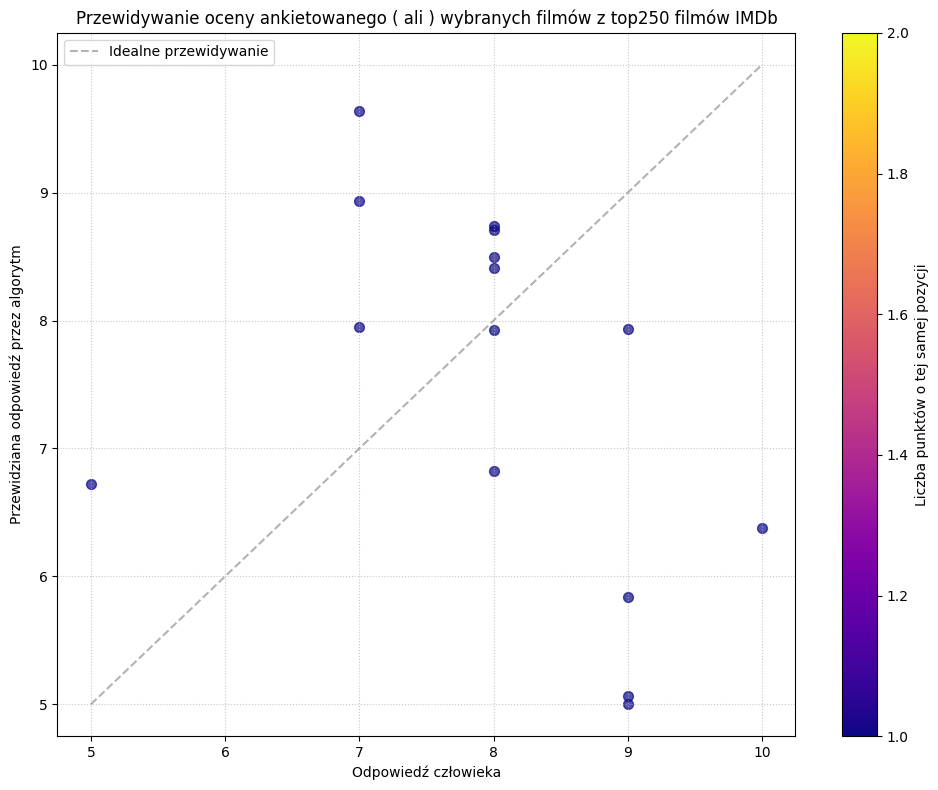

In [294]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import Counter # Import Counter for easily counting occurrences
from matplotlib.colors import Normalize # For normalizing counts to colormap range
import numpy as np
import math

chosenRating = "rating_ali"
yTest, yPred = globalTrainingSet

# --- DEBUGGING AND FIX START ---
print(f"Shape of yTest before flattening: {yTest.shape}")
print(f"Shape of yPred before flattening: {yPred.shape}")

# Flatten the arrays to ensure they are 1D
yTest_flat = np.ravel(yTest)
yPred_flat = np.ravel(yPred)

# --- DEBUGGING AND FIX END ---

minimal = yTest_flat.min() if yTest_flat.min() < yPred_flat.min() else yPred_flat.min()
maximal = yTest_flat.max() if yTest_flat.max() > yPred_flat.max() else yPred_flat.max()

x = range(math.floor(minimal),math.ceil(maximal+1),1)
y = range(math.floor(minimal),math.ceil(maximal+1),1)

# Pass the flattened arrays directly to zip
data_points = list(zip(yTest_flat, yPred_flat))

point_counts = Counter(data_points)

unique_points = list(point_counts.keys())
counts = np.array(list(point_counts.values()))

min_count = counts.min()
max_count = counts.max()

#('viridis', 'plasma', 'hot', 'magma', 'cool')
cmap = cm.plasma

norm = Normalize(vmin=min_count, vmax=max_count if max_count > min_count else min_count + 1)


plt.figure(figsize=(10, 8))

for (test_val, pred_val) in unique_points:
    count = point_counts[(test_val, pred_val)]
    color = cmap(norm(count))
    plt.scatter(test_val, pred_val, color=color, s=50, alpha=0.7)

plt.plot(x, y, color='gray', alpha=0.6, linestyle='--', label='Idealne przewidywanie')

plt.xlabel("Odpowiedź człowieka")
plt.ylabel("Przewidziana odpowiedź przez algorytm")

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Liczba punktów o tej samej pozycji')


chosenRating_name = chosenRating.replace("rating_", "")
plt.title(f"Przewidywanie oceny ankietowanego ( {chosenRating_name} ) wybranych filmów z top250 filmów IMDb")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:

yTest, yPred = globalTrainingSet

print(calculate_average_human_ai_difference(yTest, yPred))

[11.87803642]


In [ ]:

yTest, yPred = globalTrainingSet

AvgDifference = 0
for (x,y) in zip(yTest, yPred):
    AvgDifference += abs(x-y)*2**3 
    print(f"first: x = {x}, y ={y}, second: {AvgDifference} ")
print(AvgDifference)
AvgDifference /= len(yTest)
print(len(yTest))

print(AvgDifference)

first: x = 7, y =[9.97553398], second: [23.80427181] 
first: x = 7, y =[8.14053554], second: [32.92855612] 
first: x = 5, y =[6.55861286], second: [45.39745899] 
first: x = 8, y =[8.97262766], second: [53.17848028] 
first: x = 9, y =[8.74220773], second: [55.24081845] 
first: x = 7, y =[7.38321945], second: [58.30657407] 
first: x = 10, y =[8.10117777], second: [73.49715191] 
first: x = 8, y =[8.29820088], second: [75.88275897] 
first: x = 8, y =[8.59095267], second: [80.61038037] 
first: x = 8, y =[8.36633969], second: [83.5410979] 
first: x = 9, y =[4.50871857], second: [119.47134937] 
first: x = 8, y =[8.1865097], second: [120.96342694] 
first: x = 9, y =[4.81861919], second: [154.41447343] 
[154.41447343]
13
[11.87803642]


In [ ]:
print(globalTrainingSet)

(35      6
119     5
192     8
144     6
86      9
236     8
124     8
37      8
196     6
218     9
244    10
57      8
100     8
Name: rating_ali, dtype: int64, array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], dtype=int64))


dobre wyniki:

[{'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 64, 32), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (32, 64, 64, 32), 'max_iter': 10000}, {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (16, 32, 64, 32, 16, 8), 'max_iter': 10000}]

[[2.7344830610573565], [2.567023751299407], [2.42089364477507]]
